In [1]:
# Import libraries

from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.ml.feature import Tokenizer, HashingTF, IDF 
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.sql.functions import col
from pyspark.sql import functions as F

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import os
import sys
from pandas import DataFrame
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
InteractiveShell.ast_node_interactivity = "all" 

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

%matplotlib inline

# Spark

## Create Spark Session 

In [3]:
sc = SparkContext("local[*]")
spark = SparkSession(sc)

## Convert Each CSV File into Spark DataFrame (except for Tip)
#### And clean the DataFrame if necessary 

### 1. Review

In [4]:
# Use escape and multiLine = True to handle the spaces/gaps in the text column. It was previously messing up 
# the entire Spark DataFrame without those elements. 

review = spark.read.option("escape","\"").csv('yelp-dataset/yelp_review.csv', sep=',', multiLine = True, header = True)

In [4]:
review.show()

+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+
|           review_id|             user_id|         business_id|stars|      date|                text|useful|funny|cool|
+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+
|vkVSCC7xljjrAI4UG...|bv2nCi5Qv5vroFiqK...|AEx2SYEUJmTxVVB18...|    5|2016-05-28|Super simple plac...|     0|    0|   0|
|n6QzIUObkYshz4dz2...|bv2nCi5Qv5vroFiqK...|VR6GpWIda3SfvPC-l...|    5|2016-05-28|Small unassuming ...|     0|    0|   0|
|MV3CcKScW05u5LVfF...|bv2nCi5Qv5vroFiqK...|CKC0-MOWMqoeWf6s-...|    5|2016-05-28|Lester's is locat...|     0|    0|   0|
|IXvOzsEMYtiJI0CAR...|bv2nCi5Qv5vroFiqK...|ACFtxLv8pGrrxMm6E...|    4|2016-05-28|Love coming here....|     0|    0|   0|
|L_9BTb55X0GDtThi6...|bv2nCi5Qv5vroFiqK...|s2I_Ni76bjJNK9yG6...|    4|2016-05-28|Had their chocola...|     0|    0|   0|
|HRPm3vEZ_F-33TYVT...|_4iMDXbXZ1

In [5]:
# Number of rows in spark dataframe to ensure accuracy of reading CSV file 

review.count()

5261668

In [6]:
# Print schema and convert data types into pandas DataFrame 

print('Data overview')
review.printSchema()
print('Columns overview')
pd.DataFrame(review.dtypes, columns = ['Column Name','Data type'])

Data overview
root
 |-- review_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- business_id: string (nullable = true)
 |-- stars: string (nullable = true)
 |-- date: string (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: string (nullable = true)
 |-- funny: string (nullable = true)
 |-- cool: string (nullable = true)

Columns overview


Column Name Data type
0    review_id    string
1      user_id    string
2  business_id    string
3        stars    string
4         date    string
5         text    string
6       useful    string
7        funny    string
8         cool    string

### 2. User

In [5]:
user = spark.read.option("escape","\"").csv('yelp-dataset/yelp_user.csv', sep=',', multiLine = True, header = True)

In [6]:
user.columns

['user_id',
 'name',
 'review_count',
 'yelping_since',
 'friends',
 'useful',
 'funny',
 'cool',
 'fans',
 'elite',
 'average_stars',
 'compliment_hot',
 'compliment_more',
 'compliment_profile',
 'compliment_cute',
 'compliment_list',
 'compliment_note',
 'compliment_plain',
 'compliment_cool',
 'compliment_funny',
 'compliment_writer',
 'compliment_photos']

In [8]:
# Show first 5 rows as pandas dataframe. Make sure it read properly as spark dataframe

user.limit(5).toPandas()

user_id    name review_count yelping_since  \
0  JJ-aSuM4pCFPdkfoZ34q0Q   Chris           10    2013-09-24   
1  uUzsFQn_6cXDh6rPNGbIFA   Tiffy            1    2017-03-02   
2  mBneaEEH5EMyxaVyqS-72A    Mark            6    2015-03-13   
3  W5mJGs-dcDWRGEhAzUYtoA  Evelyn            3    2016-09-08   
4  4E8--zUZO1Rr1IBK4_83fg    Lisa           11    2012-07-16   

                                             friends useful funny cool fans  \
0  0njfJmB-7n84DlIgUByCNw, rFn3Xe3RqHxRSxWOU19Gpg...      0     0    0    0   
1                                               None      0     0    0    0   
2                                               None      0     0    0    0   
3                                               None      0     0    0    0   
4                                               None      4     0    0    0   

  elite  ... compliment_more compliment_profile compliment_cute  \
0  None  ...               0                  0               0   
1  None  ...               0                  0               0   
2  None  ...               0                  0               0   
3  None  ...               0                  0               0   
4  None  ...               0                  0               0   

  compliment_list compliment_note compliment_plain compliment_cool  \
0               0               0                0               0   
1               0               0                0               0   
2               0               0                0               0   
3               0               0                0               0   
4               0               0                0               0   

  compliment_funny compliment_writer compliment_photos  
0                0                 0                 0  
1                0                 0                 0  
2                0                 0                 0  
3                0                 0                 0  
4                0                 1                 0  

[5 rows x 22 columns]

In [44]:
# Number of rows in spark dataframe 

user.count()

1326100

### 3. Business Attributes

In [7]:
attributes = spark.read.option("escape","\"").csv('yelp-dataset/yelp_business_attributes.csv', sep=',', multiLine = True, header = True)

In [10]:
# There are many columns, so print them all to see if any of them could be useful later on. 

attributes.columns

['business_id',
 'AcceptsInsurance',
 'ByAppointmentOnly',
 'BusinessAcceptsCreditCards',
 'BusinessParking_garage',
 'BusinessParking_street',
 'BusinessParking_validated',
 'BusinessParking_lot',
 'BusinessParking_valet',
 'HairSpecializesIn_coloring',
 'HairSpecializesIn_africanamerican',
 'HairSpecializesIn_curly',
 'HairSpecializesIn_perms',
 'HairSpecializesIn_kids',
 'HairSpecializesIn_extensions',
 'HairSpecializesIn_asian',
 'HairSpecializesIn_straightperms',
 'RestaurantsPriceRange2',
 'GoodForKids',
 'WheelchairAccessible',
 'BikeParking',
 'Alcohol',
 'HasTV',
 'NoiseLevel',
 'RestaurantsAttire',
 'Music_dj',
 'Music_background_music',
 'Music_no_music',
 'Music_karaoke',
 'Music_live',
 'Music_video',
 'Music_jukebox',
 'Ambience_romantic',
 'Ambience_intimate',
 'Ambience_classy',
 'Ambience_hipster',
 'Ambience_divey',
 'Ambience_touristy',
 'Ambience_trendy',
 'Ambience_upscale',
 'Ambience_casual',
 'RestaurantsGoodForGroups',
 'Caters',
 'WiFi',
 'RestaurantsReservati

In [48]:
attributes.count()

152041

### 4. Business Hours 

In [8]:
hours = spark.read.csv("yelp-dataset/yelp_business_hours.csv", header=True)

In [12]:
hours.limit(5).toPandas()

business_id     monday    tuesday  wednesday   thursday  \
0  FYWN1wneV18bWNgQjJ2GNg  7:30-17:0  7:30-17:0  7:30-17:0  7:30-17:0   
1  He-G7vWjzVUysIKrfNbPUQ   9:0-20:0   9:0-20:0   9:0-20:0   9:0-20:0   
2  KQPW8lFf1y5BT2MxiSZ3QA       None       None       None       None   
3  8DShNS-LuFqpEWIp0HxijA  10:0-21:0  10:0-21:0  10:0-21:0  10:0-21:0   
4  PfOCPjBrlQAnz__NXj9h_w   11:0-1:0   11:0-1:0   11:0-1:0   11:0-1:0   

      friday   saturday     sunday  
0  7:30-17:0       None       None  
1   9:0-16:0   8:0-16:0       None  
2       None       None       None  
3  10:0-21:0  10:0-21:0  11:0-19:0  
4   11:0-1:0   11:0-2:0   11:0-0:0

In [54]:
hours.count()

174567

### 5. Business

In [158]:
business = spark.read.option("escape","\"").csv('yelp-dataset/yelp_business.csv', sep=',', multiLine = True, header = True)
business.show()

+--------------------+--------------------+------------------+--------------------+--------------+-----+-----------+-------------+--------------+-----+------------+-------+--------------------+
|         business_id|                name|      neighborhood|             address|          city|state|postal_code|     latitude|     longitude|stars|review_count|is_open|          categories|
+--------------------+--------------------+------------------+--------------------+--------------+-----+-----------+-------------+--------------+-----+------------+-------+--------------------+
|FYWN1wneV18bWNgQj...|  "Dental by Design"|              null|"4855 E Warner Rd...|     Ahwatukee|   AZ|      85044|   33.3306902|  -111.9785992|  4.0|          22|      1|Dentists;General ...|
|He-G7vWjzVUysIKrf...|"Stephen Szabo Sa...|              null|"3101 Washington Rd"|      McMurray|   PA|      15317|   40.2916853|   -80.1048999|  3.0|          11|      1|Hair Stylists;Hai...|
|KQPW8lFf1y5BT2Mxi...|"Western

In [14]:
business.limit(5).toPandas()

business_id                        name neighborhood  \
0  FYWN1wneV18bWNgQjJ2GNg          "Dental by Design"         None   
1  He-G7vWjzVUysIKrfNbPUQ       "Stephen Szabo Salon"         None   
2  KQPW8lFf1y5BT2MxiSZ3QA     "Western Motor Vehicle"         None   
3  8DShNS-LuFqpEWIp0HxijA          "Sports Authority"         None   
4  PfOCPjBrlQAnz__NXj9h_w  "Brick House Tavern + Tap"         None   

                            address            city state postal_code  \
0        "4855 E Warner Rd, Ste B9"       Ahwatukee    AZ       85044   
1              "3101 Washington Rd"        McMurray    PA       15317   
2          "6025 N 27th Ave, Ste 1"         Phoenix    AZ       85017   
3  "5000 Arizona Mills Cr, Ste 435"           Tempe    AZ       85282   
4                    "581 Howe Ave"  Cuyahoga Falls    OH       44221   

     latitude     longitude stars review_count is_open  \
0  33.3306902  -111.9785992   4.0           22       1   
1  40.2916853   -80.1048999   3.0           11       1   
2  33.5249025  -112.1153098   1.5           18       1   
3  33.3831468  -111.9647254   3.0            9       0   
4  41.1195346   -81.4756898   3.5          116       1   

                                          categories  
0  Dentists;General Dentistry;Health & Medical;Or...  
1  Hair Stylists;Hair Salons;Men's Hair Salons;Bl...  
2  Departments of Motor Vehicles;Public Services ...  
3                            Sporting Goods;Shopping  
4  American (New);Nightlife;Bars;Sandwiches;Ameri...

In [58]:
business.count()

174567

### 6. Check-in

In [11]:
checkin = spark.read.csv( "yelp-dataset/yelp_checkin.csv", header=True)
#checkin.show()

In [61]:
checkin.limit(5).toPandas()

business_id weekday   hour checkins
0  3Mc-LxcqeguOXOVT_2ZtCg     Tue   0:00       12
1  SVFx6_epO22bZTZnKwlX7g     Wed   0:00        4
2  vW9aLivd4-IorAfStzsHww     Tue  14:00        1
3  tEzxhauTQddACyqdJ0OPEQ     Fri  19:00        1
4  CEyZU32P-vtMhgqRCaXzMA     Tue  17:00        1

In [62]:
checkin.count()

3911218

# Spark Data Exploration

## Business Count by US State

In [ ]:
# Define list of US States so that non-US States can be removed in next step

states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

In [12]:
# Filter to only US States and find the States with the most businesses in the dataset using Groupby, Count, Sort_values

usa = business.filter(business.state.isin(states))

top_states = usa.toPandas()
top_states = top_states.groupby(top_states.state).count().sort_values('business_id', ascending = False)

top_states = top_states[['business_id']].reset_index()
top_states

state  business_id
0     AZ        52214
1     NV        33086
2     NC        12956
3     OH        12609
4     PA        10109
5     WI         4754
6     IL         1852
7     SC          679
8     NY           18
9     CA            5
10    IN            3
11    AR            2
12    CO            2
13    VT            2
14    WA            1
15    VA            1
16    AK            1
17    NE            1
18    MT            1
19    AL            1
20    KY            1
21    GA            1
22    FL            1
23    DE            1
24    MN            1

<BarContainer object of 25 artists>

Text(0.5, 0, 'State')

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Business Count per US State')

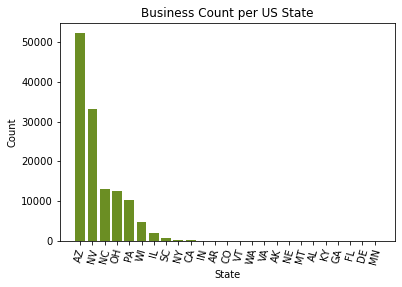

In [148]:
# Plot the above information as a bar plot. 

plt.bar(top_states['state'], top_states['business_id'], color='olivedrab')
plt.xlabel('State')
# Make labels legible 
plt.xticks(rotation = 75)
plt.ylabel('Count')
plt.title('Business Count per US State')
# Save image to computer 
plt.savefig('businessCountPerState.png',dpi=300, bbox_inches = "tight")
plt.show()

## Check-Ins by Business (Top 5)

In [14]:
checkin.show()

+--------------------+-------+-----+--------+
|         business_id|weekday| hour|checkins|
+--------------------+-------+-----+--------+
|3Mc-LxcqeguOXOVT_...|    Tue| 0:00|      12|
|SVFx6_epO22bZTZnK...|    Wed| 0:00|       4|
|vW9aLivd4-IorAfSt...|    Tue|14:00|       1|
|tEzxhauTQddACyqdJ...|    Fri|19:00|       1|
|CEyZU32P-vtMhgqRC...|    Tue|17:00|       1|
|9dn5pee_n2dWQfN57...|    Sun| 3:00|       5|
|6Zk5F7fsTr8n2CJTl...|    Wed| 1:00|       4|
|OE_IDW5w_W97sBcZv...|    Sat| 1:00|       1|
|gy5pr5bFAjOL5rERS...|    Sat|15:00|       1|
|r2-eAhGANXlcgQy89...|    Mon|19:00|       1|
|wiBxwslJAGDdZ2nmL...|    Mon|16:00|       1|
|08jURVR_eDvXq9scd...|    Sat|23:00|       1|
|BlWPjh2WuvQSlmYmg...|    Sun| 0:00|       1|
|6DO_2jivyxcL6SXGP...|    Wed|23:00|       1|
|wrJROwvVKHvdMVIZO...|    Thu|21:00|       3|
|uU8up3hGwW9qnzQD1...|    Fri| 0:00|       1|
|JHPq9KvMuJaC7CPAT...|    Sun|16:00|       1|
|vyzfT3_KzLi8WmInw...|    Thu| 9:00|       1|
|E4T0rQBJa0e4HIliB...|    Thu|23:0

In [15]:
# Group the check-in DataFrame by business_id and sum the check-ins. Then, join business to get the business name

df1=checkin.groupBy("business_id").agg(F.sum(checkin.checkins)).orderBy('sum(checkins)', ascending=False)
top_checkins = df1.join(business.select('business_id', 'name'),['business_id']).orderBy('sum(checkins)', ascending=False)
# Comvert to Pandas DataFrame for visualization 
top_checkins = top_checkins.toPandas()

In [16]:
# Use head to get top 5 businesses 

top_checkins = top_checkins.head(5)
# Find total checkins in top 5 businesses
total = sum(top_checkins['sum(checkins)'])
# Create new column with percentage within the top 5 businesses
top_checkins['percentage'] = top_checkins['sum(checkins)']/total

([<matplotlib.patches.Wedge at 0x7fde286c5ac0>,
 [Text(-1.078634959600902, 0.5258770045616756, '"McCarran International Airport"'),
  Text(0.05051265678048118, -1.0988396022645788, '"Phoenix Sky Harbor International Airport"'),
  Text(1.087825304692522, -0.16320571825344224, '"Charlotte Douglas International Airport"'),
  Text(0.8781548361473772, 0.6624530804147365, '"The Cosmopolitan of Las Vegas"'),
  Text(0.2997813790673264, 1.0583624732408514, '"ARIA Resort & Casino"')],
 [Text(-0.6292037264338595, 0.30676158599431075, '35.6%'),
  Text(0.027552358243898827, -0.5993670557806793, '30.3%'),
  Text(0.5933592571050119, -0.08902130086551395, '13.5%'),
  Text(0.47899354698947844, 0.3613380438625835, '11.9%'),
  Text(0.16351711585490528, 0.5772886217677371, '8.8%')])

(-1.2097121420092378,
 1.1156136563567878,
 -1.1087795457019156,
 1.1463279708284915)

Text(0.5, 1.0, 'Top 5 Check-In Companies')

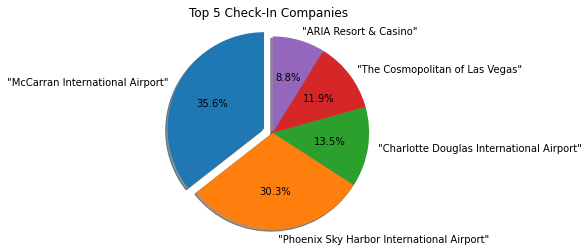

In [126]:
# Percentages ONLY related to top 5 sum(checkins)

labels = top_checkins['name']
sizes = top_checkins['percentage']
# Make top business explode
explode = (0.1, 0, 0, 0, 0)  # only "explode" the 1st slice 

# Plot pie chart
fig1, ax1 = plt.subplots()

ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  
plt.title('Top 5 Check-In Companies')
plt.savefig('top5CheckinCompanies.png',dpi=300, bbox_inches = "tight")

plt.show()

## Check-ins by Hour

In [18]:
# Group check-in DF by hour and sum check-ins 

df_2 = checkin.groupby('hour').agg(F.sum('checkins')).toPandas().sort_values(['sum(checkins)'], ascending = False)
df_2

hour  sum(checkins)
19   1:00      1351327.0
13  19:00      1311745.0
23   0:00      1285754.0
7    2:00      1227713.0
3   20:00      1173052.0
20  23:00      1155790.0
16  18:00      1105046.0
15  22:00      1083512.0
5   21:00      1071933.0
14   3:00       941489.0
22  17:00       872146.0
17  16:00       741470.0
10   4:00       657420.0
9   15:00       542627.0
0    5:00       431336.0
1   14:00       370439.0
6    6:00       289968.0
12  13:00       239728.0
11   7:00       210909.0
2   12:00       162443.0
18   8:00       140767.0
8   11:00       103510.0
4    9:00        94885.0
21  10:00        83349.0

<AxesSubplot:xlabel='hour'>

Text(0.5, 0, 'Hour')

Text(0, 0.5, 'Sum')

Text(0.5, 1.0, 'Chekins per Hour')

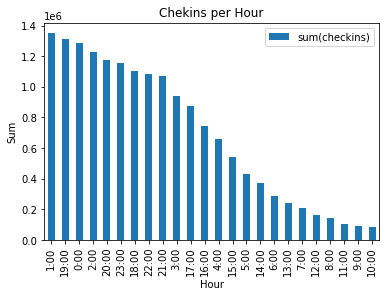

In [128]:
# Plot information from above into bar chart

df_2.plot(kind = 'bar', x = 'hour')
plt.xlabel('Hour')
plt.ylabel('Sum')
plt.title('Chekins per Hour')
plt.savefig('checkinPerHour.png',dpi=300, bbox_inches = "tight")
plt.show()

## Check-Ins by Star Rating

In [20]:
# Join check-in and business together to get businesses' average stars in check-in DF 

checkin_stars = checkin.join(business.select('business_id', 'stars'),['business_id'])
checkin_by_star = checkin_stars.groupby(checkin_stars.stars).agg(F.sum(checkin_stars.checkins)).orderBy('stars', ascending=False)

In [21]:
checkin_by_star = checkin_by_star.toPandas().reset_index()

In [22]:
checkin_by_star = checkin_by_star.drop('index', axis=1)
checkin_by_star

stars  sum(checkins)
0   5.0       403127.0
1   4.5      2488737.0
2   4.0      5439064.0
3   3.5      4323605.0
4   3.0      2524465.0
5   2.5      1020944.0
6   2.0       334328.0
7   1.5        98411.0
8   1.0        15677.0

<BarContainer object of 9 artists>

Text(0.5, 0, 'Sum')

Text(0, 0.5, 'Star Rating')

Text(0.5, 1.0, 'Check-Ins by Star Rating')

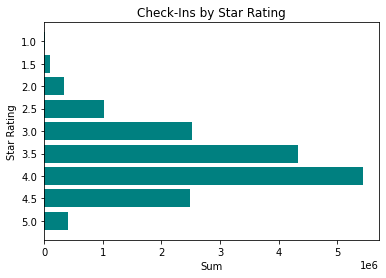

In [129]:
# Plot a horizontal bar chart with the information from above

plt.barh(checkin_by_star.stars, checkin_by_star['sum(checkins)'], color='teal')
plt.xlabel('Sum')
plt.ylabel('Star Rating')
plt.title('Check-Ins by Star Rating')
plt.savefig('checkinByStar.png',dpi=300, bbox_inches = "tight")
plt.show()

## Review Count by Star Rating

In [25]:
# Group business DF by star ratings, and usm the review counts

star_count = business.groupBy(business['stars']).agg(F.sum(business['review_count']))
# Order by star ratings
star_count = star_count.orderBy(star_count['stars'], ascending=False)
star_count = star_count.toPandas()

<BarContainer object of 9 artists>

Text(0.5, 0, 'Sum')

Text(0, 0.5, 'Star Rating')

Text(0.5, 1.0, 'Review Count by Star Rating')

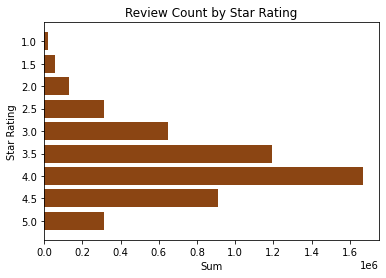

In [145]:
# Plot horizontal bar chart with above information 

plt.barh(star_count.stars, star_count['sum(review_count)'], color='saddlebrown')
plt.xlabel('Sum')
plt.ylabel('Star Rating')
plt.title('Review Count by Star Rating')
plt.savefig('reviewcountbystar.png',dpi=300, bbox_inches = "tight")
plt.show()

## Sum Useful Votes by Stars

In [27]:
# Use Groupby and sum on review DF 

review_useful = review.groupBy(review['business_id']).agg(F.sum(review['useful']))
review_useful.show()

+--------------------+-----------+
|         business_id|sum(useful)|
+--------------------+-----------+
|RtUvSWO_UZ8V3Wpj0...|     1414.0|
|jXjglUcr2bDKdoV4l...|       19.0|
|N3J76CRP2H52NUo4V...|       78.0|
|jOqh0eVjqtUOpZ9AZ...|       51.0|
|BMAflH82OUIMl2mHt...|       49.0|
|_ixV2SWDy7w8jzEAH...|      436.0|
|j0_CApMCHDJBYJg1X...|      212.0|
|CAmPPSKoFCd8zo2bx...|       37.0|
|YjPWt-V5oMkakdRWr...|       66.0|
|JsUytp_MuZ4AX5JWf...|       78.0|
|JFhfVTt_8xNjtwqSD...|      157.0|
|X26lmoKvv_KvW6WcA...|        7.0|
|MgSd4P3ATkiywbbra...|      232.0|
|JLbgvGM4FXh9zNP4O...|     1567.0|
|1NmGVWYlF4iMngM6a...|       73.0|
|cz5vz-893D3LNH3TM...|      604.0|
|gogO5RF4Rqz2THF1A...|      305.0|
|b-dMCUh7T2Kya1O7Z...|       99.0|
|cdkzUI1tXc8rUMF33...|       31.0|
|Nf-Y0Ozjtff417vPS...|        9.0|
+--------------------+-----------+
only showing top 20 rows



In [28]:
# join business DF and DF from above to get average star ratings

pleaseWork = business[['stars','business_id']].join(review_useful, how='left', on='business_id')
pleaseWork.show()

+--------------------+-----+-----------+
|         business_id|stars|sum(useful)|
+--------------------+-----+-----------+
|fNMVV_ZX7CJSDWQGd...|  3.5|        5.0|
|l09JfMeQ6ynYs5MCJ...|  3.0|       25.0|
|8DShNS-LuFqpEWIp0...|  3.0|        4.0|
|NmZtoE3v8RdSJEczY...|  2.0|        4.0|
|IQSlT5jGE6CCDhSG0...|  3.0|       11.0|
|FYWN1wneV18bWNgQj...|  4.0|       41.0|
|KQPW8lFf1y5BT2Mxi...|  1.5|       10.0|
|OD2hnuuTJI9uotcKy...|  1.5|       13.0|
|o9eMRCWt5PkpLDE0g...|  4.0|        1.0|
|b2I2DXtZVnpUMCXp1...|  3.5|       11.0|
|xcgFnd-MwkZeO5G2H...|  4.0|       61.0|
|EsMcGiZaQuG1OOvL9...|  5.0|        8.0|
|kCoE3jvEtg6UVz5SO...|  4.0|        0.0|
|XOSRcvtaKc_Q5H1SA...|  4.5|        3.0|
|TGWhGNusxyMaA4kQV...|  5.0|       16.0|
|Gu-xs3NIQTj3Mj2xY...|  3.5|       41.0|
|He-G7vWjzVUysIKrf...|  3.0|       61.0|
|0FMKDOU8TJT1x87OK...|  5.0|       54.0|
|lHYiCS-y8AFjUitv6...|  4.0|        7.0|
|Y0eMNa5C-YU1RQOZf...|  5.0|        8.0|
+--------------------+-----+-----------+
only showing top

In [29]:
# Use Groupby and sum, orderby, and then convert to Pandas DF

star_useful = pleaseWork.groupBy(pleaseWork['stars']).agg(F.sum(pleaseWork['sum(useful)']))
star_useful = star_useful.orderBy(star_useful['stars'], ascending=False)
star_useful = star_useful.toPandas()
star_useful

stars  sum(sum(useful))
0   5.0          381653.0
1   4.5         1248251.0
2   4.0         2109397.0
3   3.5         1526557.0
4   3.0          985531.0
5   2.5          509508.0
6   2.0          271836.0
7   1.5          174604.0
8   1.0           80521.0

<BarContainer object of 9 artists>

Text(0.5, 0, 'Star Rating')

Text(0, 0.5, 'Total Useful Votes')

Text(0.5, 1.0, 'Useful Votes by Star Rating')

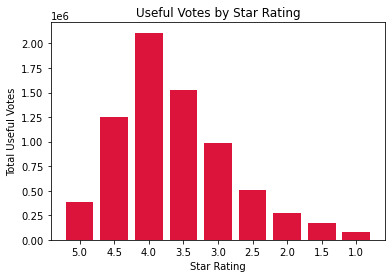

In [143]:
# Plot bar chart of information above

plt.bar(star_useful.stars, star_useful['sum(sum(useful))'], color='crimson')
plt.xlabel('Star Rating')
plt.ylabel('Total Useful Votes')
plt.title('Useful Votes by Star Rating')
plt.savefig('usefulbystar.png',dpi=300, bbox_inches = "tight")
plt.show()

## Useful count by business

In [31]:
# Use Orderby, join to get business name 

useful_business = pleaseWork.orderBy(['sum(useful)'], ascending=False)

useful_business = useful_business.join(business[['name', 'business_id']], how='left', on='business_id')
# Limit results to top 10 
useful_business = useful_business.limit(10).toPandas()

In [32]:
useful_business

business_id stars  sum(useful)                             name
0  DN0b4Un8--Uf6SEWLeh0UA   3.0      61488.0           "Amy's Baking Company"
1  RESDUcs7fIiihp38-d6_6g   4.0      11006.0               "Bacchanal Buffet"
2  K7lWdNUhCbcnEvI0NhGewg   3.5       8087.0                   "Wicked Spoon"
3  5LNZ67Yw9RD6nf4_UhXOjw   4.0       7894.0  "The Cosmopolitan of Las Vegas"
4  u02xse4VO7lkyF4r7ARNdw   1.5       6838.0               "Suburban Express"
5  MpmFFw0GE_2iRFPdsRpJbA   4.0       6310.0                   "XS Nightclub"
6  SMPbvZLSMMb7KU76YNYMGg   3.5       6223.0           "ARIA Resort & Casino"
7  Iq7NqQD-sESu3vr9iEGuTA   4.5       5794.0        "Butters Pancakes & Café"
8  2weQS-RnoOBhb1KsHKyoSQ   3.5       5684.0                     "The Buffet"
9  El4FC8jcawUVgw_0EIcbaQ   3.0       5620.0                "MGM Grand Hotel"

<BarContainer object of 10 artists>

Text(0.5, 0, 'Company Name')

Text(0, 0.5, 'Total Useful Votes')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

Text(0.5, 1.0, 'Useful Votes by Company')

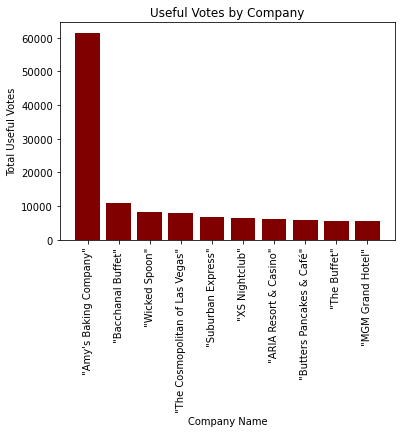

In [142]:
# Plot above information as bar chart

plt.bar(useful_business.name, useful_business['sum(useful)'], color='maroon')
plt.xlabel('Company Name')
plt.ylabel('Total Useful Votes')
plt.xticks(rotation=90)
plt.title('Useful Votes by Company')
plt.savefig('usefulbycompany.png',dpi=300, bbox_inches = "tight")
plt.show()

## Star Ratings for Amy's Baking Company 

In [34]:
# Use where to get Amy's Baking Company reviews

amy_review = review.where(review.business_id=="DN0b4Un8--Uf6SEWLeh0UA")

In [35]:
# Use groupby and count 

amy_review = amy_review.groupBy(amy_review.stars).count().toPandas()

In [36]:
amy_review

stars  count
0     3     36
1     5    137
2     1    194
3     4     66
4     2     28

([<matplotlib.patches.Wedge at 0x7fde3970d0a0>,
 [Text(-0.26716458172771196, 1.0670628314538264, '3'),
  Text(-1.0882141703651014, 0.16059240149083825, '5'),
  Text(0.6152786198884752, -1.0302583267841778, '1'),
  Text(0.8127612057284952, 0.7412281851513493, '4'),
  Text(0.20862235816009747, 1.0800355140807734, '2')],
 [Text(-0.14572613548784288, 0.582034271702087, '7.8%'),
  Text(-0.5935713656536915, 0.08759585535863905, '29.7%'),
  Text(0.35891252826827713, -0.600984023957437, '42.1%'),
  Text(0.4433242940337246, 0.40430628280982683, '14.3%'),
  Text(0.11379401354187134, 0.5891102804076944, '6.1%')])

(-1.1163664580352, 1.177380896098103, -1.2108217882839978, 1.1052772342568757)

Text(0.5, 1.0, "Star Ratings for Amy's Baking Company")

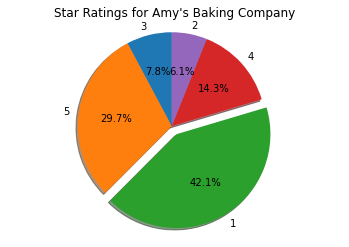

In [133]:
# Plot pie chart of Amy's Star Ratings

labels = amy_review['stars']
sizes = amy_review['count']
# only explode the 3rd slice, since it is the largest 
explode = (0, 0, 0.1, 0, 0)  

fig1, ax1 = plt.subplots()

ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  
# Use triple quotes due to the quote being in the string
plt.title("""Star Ratings for Amy's Baking Company""")
plt.savefig('amyStarRating.png',dpi=300, bbox_inches = "tight")
plt.show()

## Review Wordcloud

In [38]:
# Use where function 

amy_text = review.where(review['business_id']=='DN0b4Un8--Uf6SEWLeh0UA')
amy_text=amy_text.toPandas()

In [39]:
amy_text

review_id                 user_id             business_id  \
0    ZCTMLmTv4D5iQsbaI3B1BA  p7W-M8BdZ1Z_T0jiw1602w  DN0b4Un8--Uf6SEWLeh0UA   
1    bo8zw5C2FSkTrQJ8quutLw  LlXQ13MxNOjOFx5fJOVRJw  DN0b4Un8--Uf6SEWLeh0UA   
2    gKnz4ydr2jtbU4LWnmtUWA  NN62EGrnOwkU1sx-_NCPvw  DN0b4Un8--Uf6SEWLeh0UA   
3    jgHKpzR3FE8tdZbhoUtFlg  1iphqkZxhQum2bNeWho9-w  DN0b4Un8--Uf6SEWLeh0UA   
4    a9W7FRk67CaELcR3JmAg_A  Q368eGRAxUNAH2Ez0Whd_w  DN0b4Un8--Uf6SEWLeh0UA   
..                      ...                     ...                     ...   
456  Y8qhS1zFo4ZqVl6wAedKZA  _bn45BhoHNN6JYeZFcQq3w  DN0b4Un8--Uf6SEWLeh0UA   
457  y0JmNsy2FriLhgLaAVrXnA  woIFHDytuex2UPOsib2pwA  DN0b4Un8--Uf6SEWLeh0UA   
458  TfoYl0tZUNp2sHmDoduemA  fUowaPuKIqCS6pQQnMZsIw  DN0b4Un8--Uf6SEWLeh0UA   
459  QH6UThw5f_OrliHe1wYQZw  yPVUOv56zrYlpP7wJpJJWg  DN0b4Un8--Uf6SEWLeh0UA   
460  A8mLBytNM2zmjHgSpsuZDA  qiTy11I-yp6foxIghRfGOA  DN0b4Un8--Uf6SEWLeh0UA   

    stars        date                                               text  \
0       5  2014-01-26  ABC has become a weekly stop. We came after wa...   
1       1  2015-04-27  Awful food and Amy and her husband were very r...   
2       5  2014-07-08  One of the best place we ever eat in! We trave...   
3       1  2014-06-19  Yikes!!! I must be honest, I went in thinking ...   
4       3  2014-02-28  I ate here yesterday. I waited 45 minutes for ...   
..    ...         ...                                                ...   
456     1  2014-08-02  The worse place I've ever  been!  Food is unde...   
457     1  2013-07-25  All our food was either under cooked or way ov...   
458     1  2012-10-27  Owner was very rude.  He really did not care h...   
459     4  2015-07-04  While in town, we could help but pop into this...   
460     1  2010-08-01  In retrospect, I should have known better than...   

    useful funny  cool  
0        1    40     1  
1        9     5     3  
2        1     7     0  
3       62    10     7  
4       71    54    10  
..     ...   ...   ...  
456     20     2     4  
457    152    16     2  
458      5     4     1  
459     70   462    29  
460   3364  1481  1105  

[461 rows x 9 columns]

In [40]:
# Get all of the review words to prepare for WordCloud

text = " ".join(text for text in amy_text.text.astype(str))

In [41]:
# Set Stop words and add extras

stopwords = set(STOPWORDS)
stopwords.update(["place", "food", "restaurant","Amy", 'came', "go", "got", 'went', 'us'])

In [42]:
# Define the WordCloud

amy_wordcloud = WordCloud(stopwords=stopwords, background_color="white", width=800, height=400).generate(text)

(0.0, 1.0, 0.0, 1.0)

<Figure size 3600x2160 with 0 Axes>

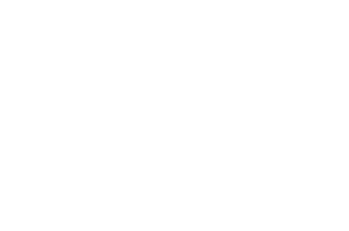

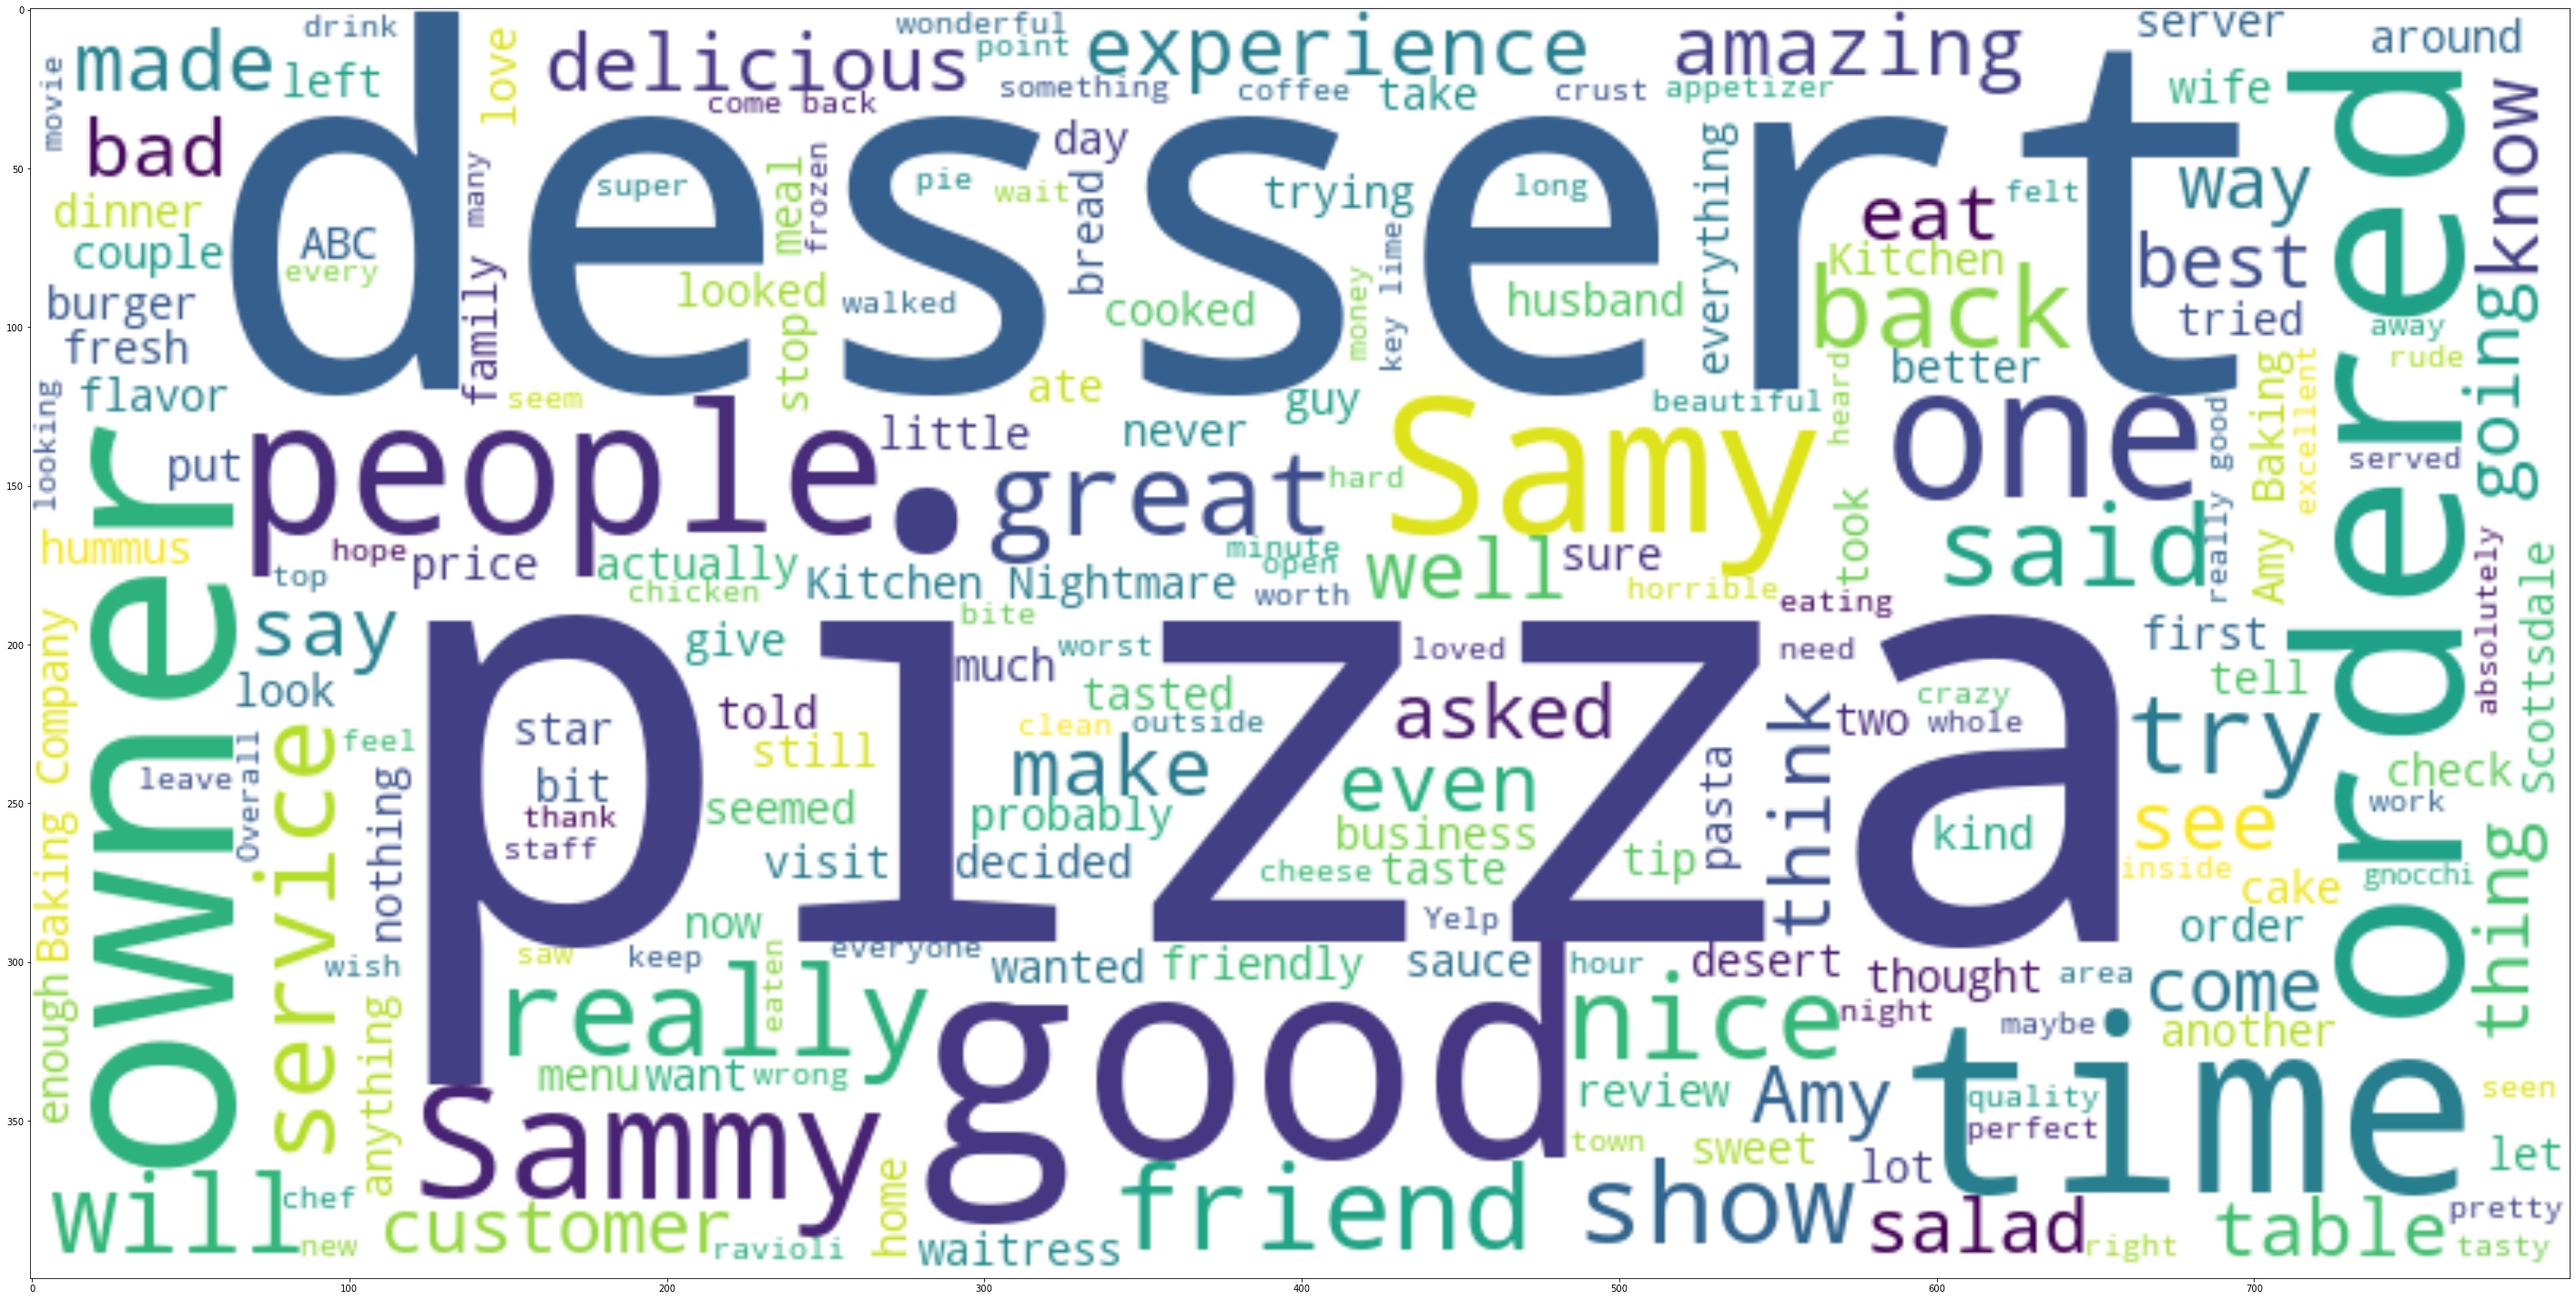

In [134]:
# Plot Amy's WordCloud

plt.axis("off")
plt.figure(figsize=(50,30))
plt.tight_layout(pad=0)
plt.imshow(amy_wordcloud, interpolation='bilinear')
plt.savefig('amyFullWordcloud.png',dpi=300, bbox_inches = "tight")
plt.show()

## Good/Bad Review Wordcloud for Amy

### Bad Amy Reviews

In [44]:
# Set bad reviews as those with star ratings = 1, 2, or 3

bad_amy = review.where(review.business_id=="DN0b4Un8--Uf6SEWLeh0UA")
bad_amy = bad_amy.where((bad_amy.stars == 1) | (bad_amy.stars == 2) | (bad_amy.stars == 3))
bad_amy = bad_amy.toPandas()

In [45]:
# Get all of the review words to prepare for WordCloud

bad_amy_text = " ".join(text for text in bad_amy.text.astype(str))

In [46]:
# Define the WordCloud

bad_amy_wordcloud = WordCloud(stopwords=stopwords, background_color="gray", width=800, height=400).generate(bad_amy_text)

(0.0, 1.0, 0.0, 1.0)

<Figure size 3600x2160 with 0 Axes>

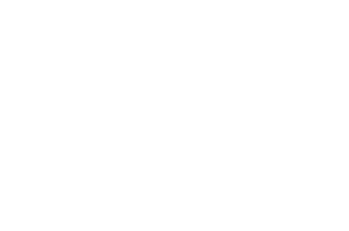

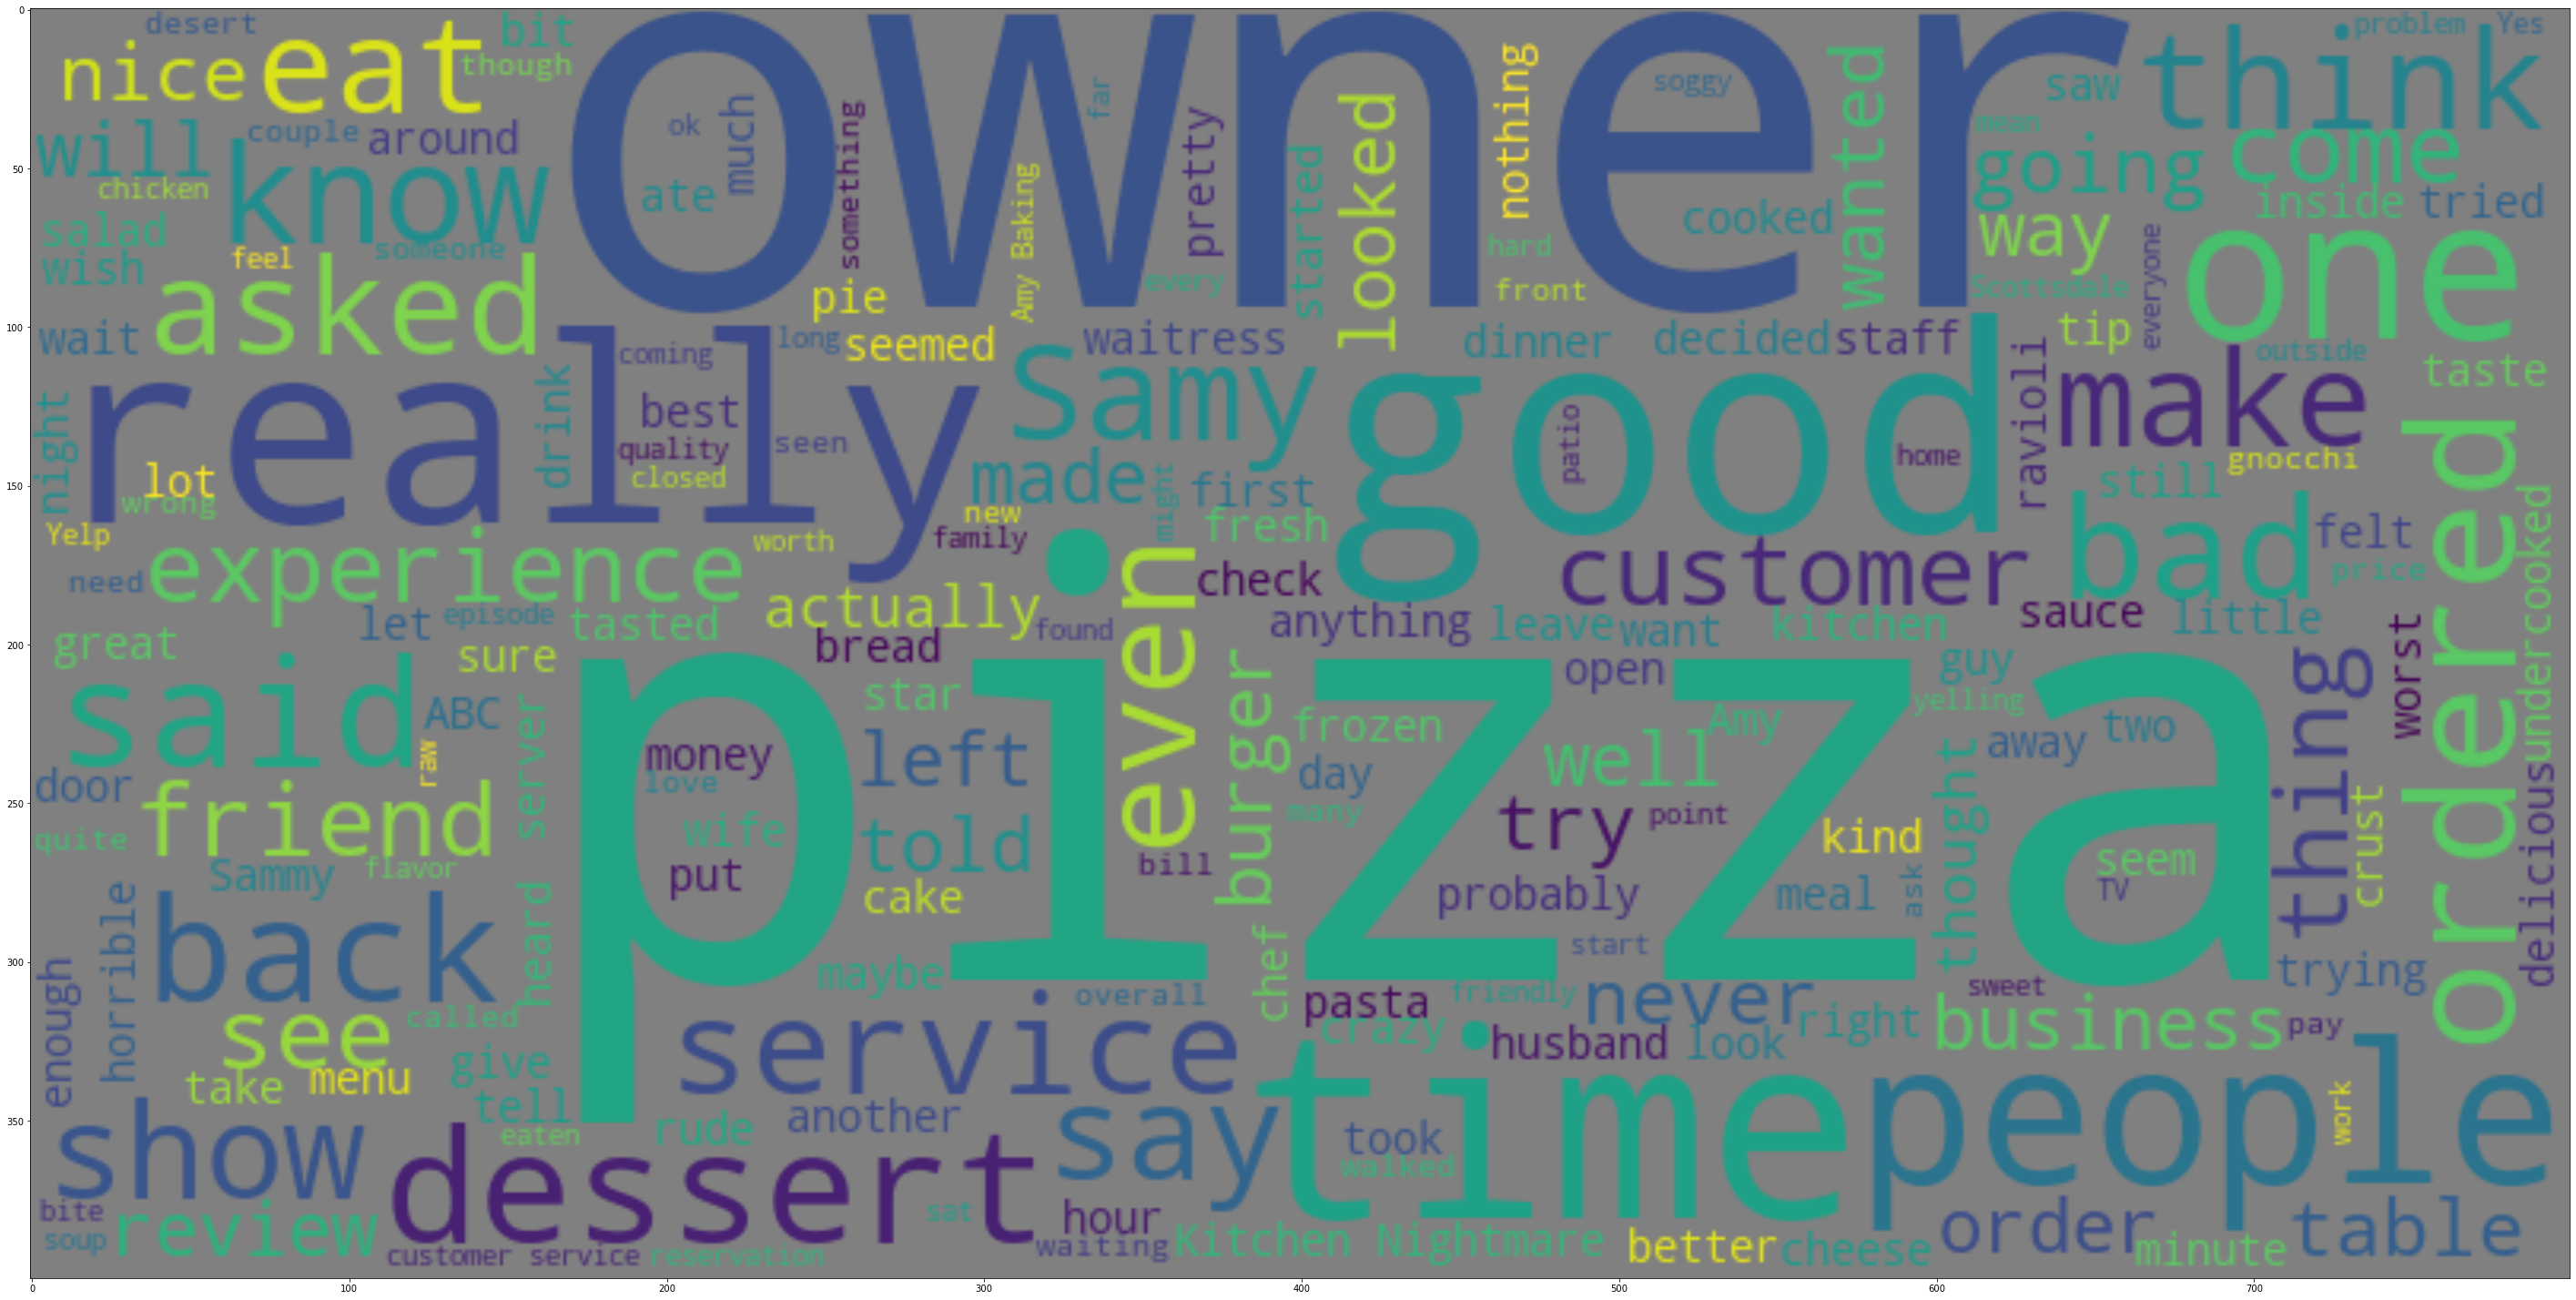

In [135]:
# Plot the WordCloud for bad reviews

plt.axis("off")
plt.figure(figsize=(50,30))
plt.tight_layout(pad=0)
plt.imshow(bad_amy_wordcloud, interpolation='bilinear')
plt.savefig('badAmy.png',dpi=300, bbox_inches = "tight")
plt.show()

### Good Amy Reviews

In [48]:
# Set good reviews as those with star ratings = 4 or 5

good_amy = review.where(review.business_id=="DN0b4Un8--Uf6SEWLeh0UA")
good_amy = good_amy.where((good_amy.stars == 4) | (good_amy.stars == 5))
good_amy = good_amy.toPandas()

In [49]:
# Get all of the review words to prepare for WordCloud

good_amy_text = " ".join(text for text in good_amy.text.astype(str))

In [50]:
# Define the WordCloud

good_amy_wordcloud = WordCloud(stopwords=stopwords, background_color="white", width=800, height=400).generate(good_amy_text)

(0.0, 1.0, 0.0, 1.0)

<Figure size 3600x2160 with 0 Axes>

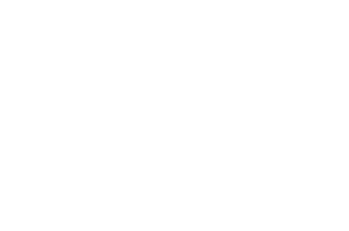

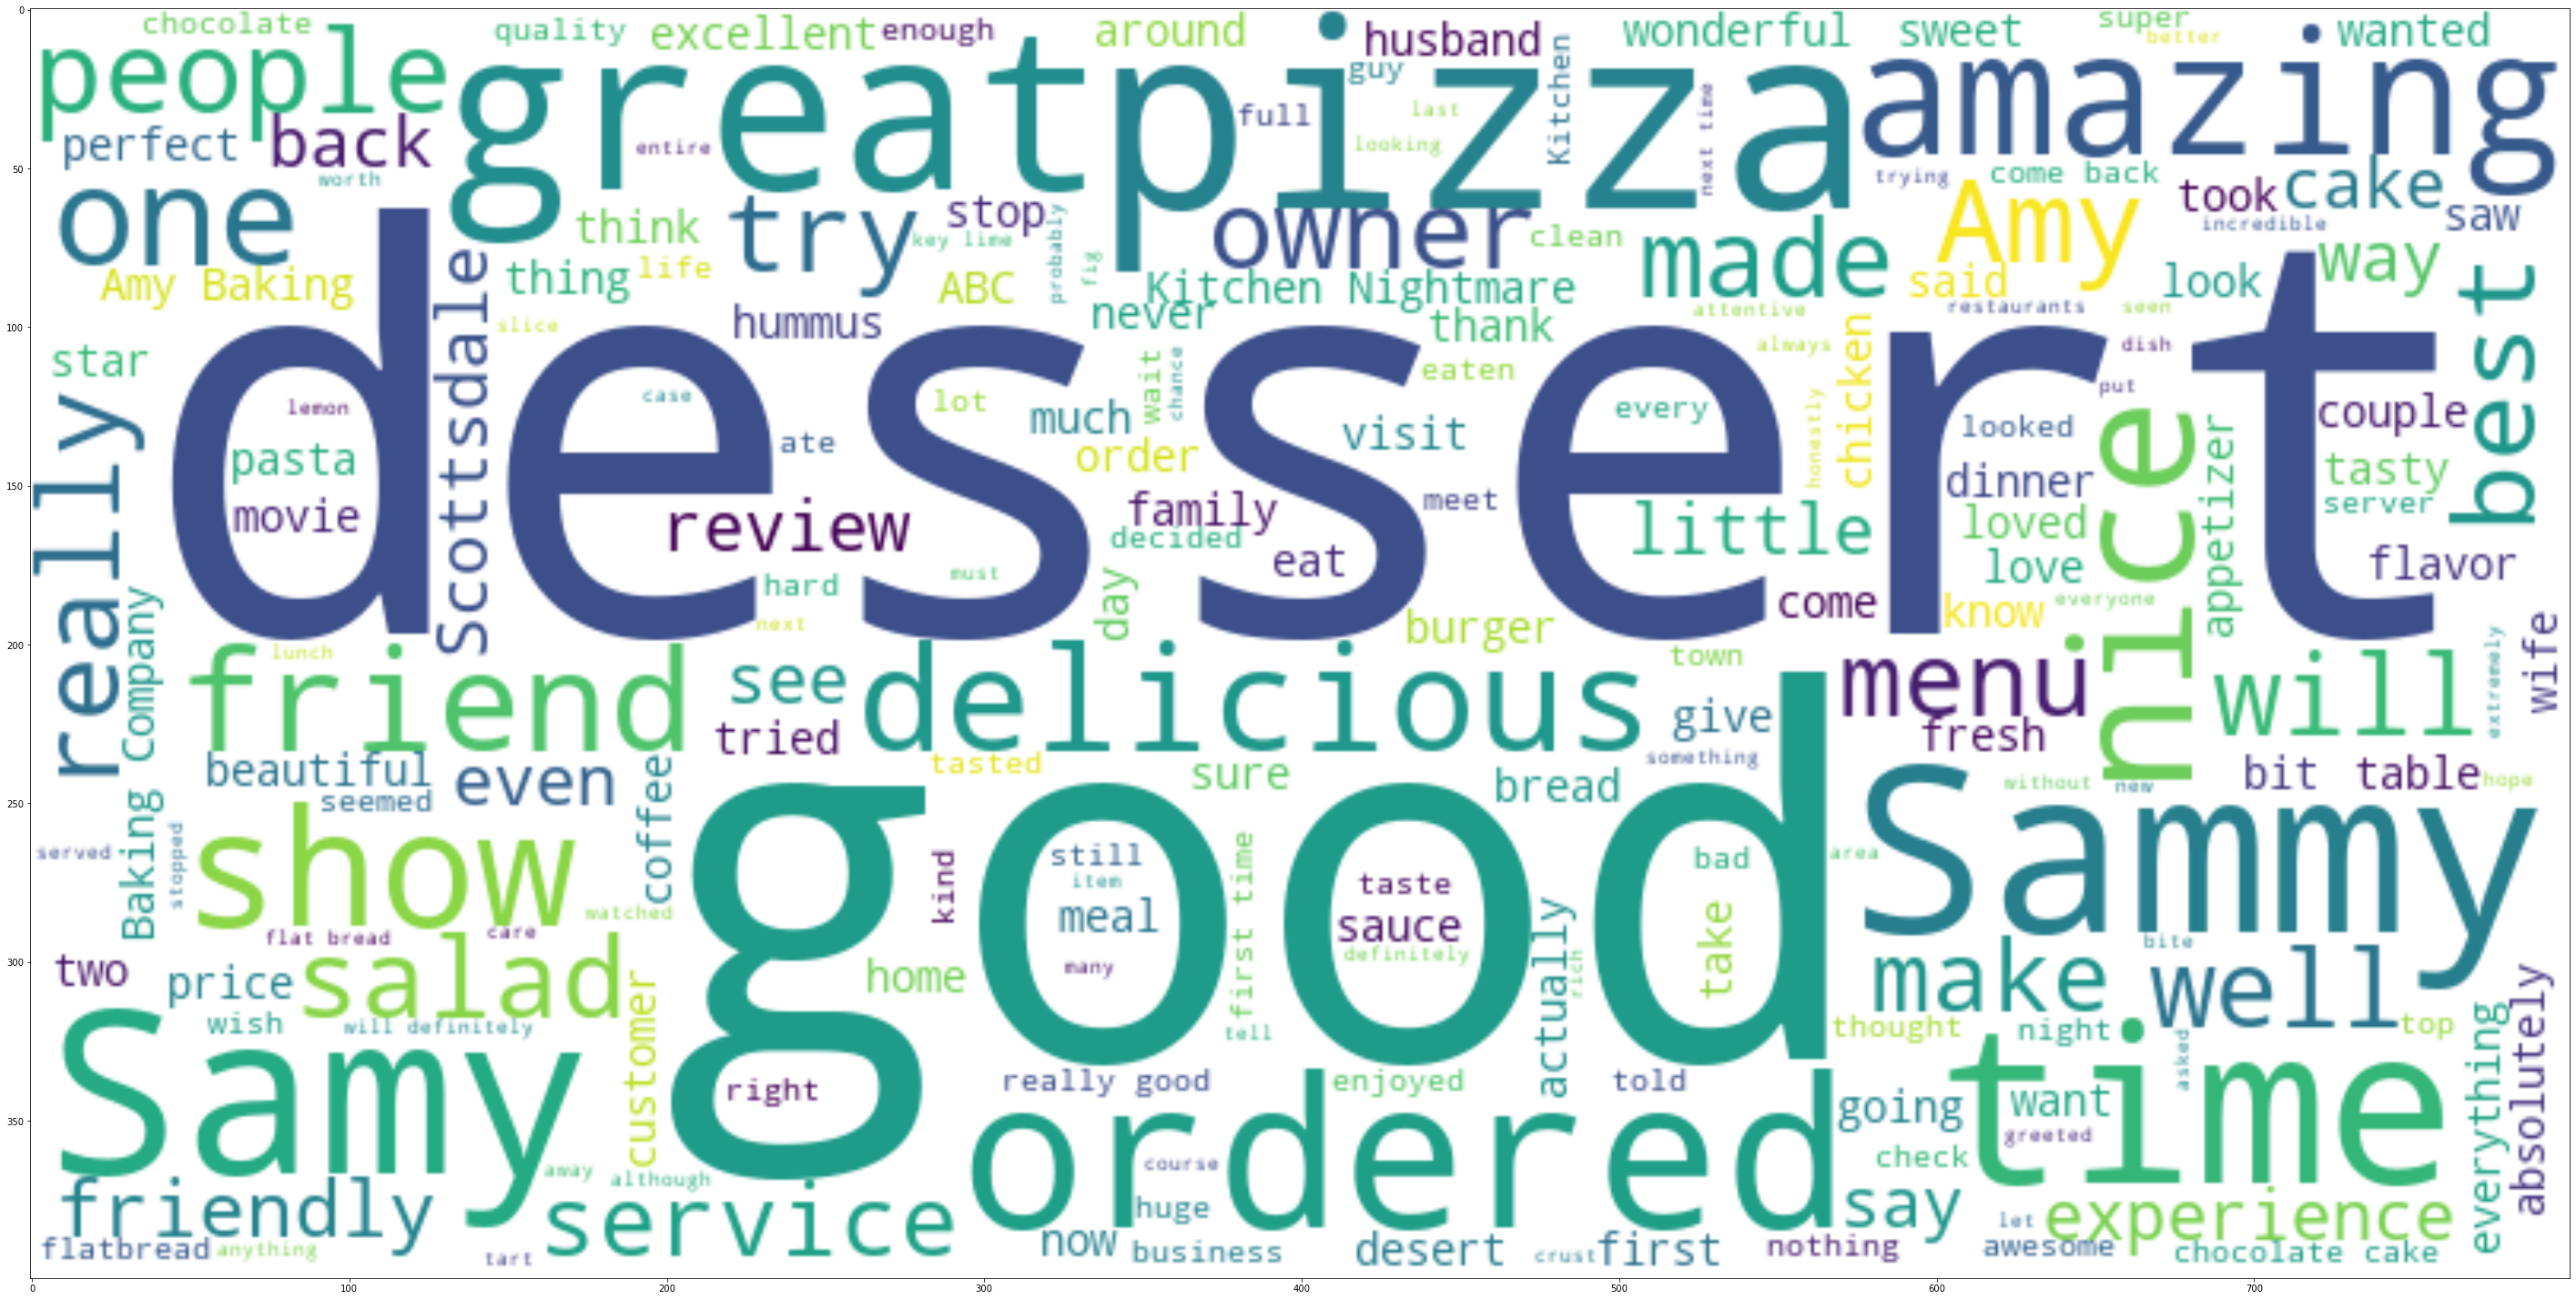

In [136]:
# Plot the WordCloud for good reviews

plt.axis("off")
plt.figure(figsize=(50,30))
plt.tight_layout(pad=0)
plt.imshow(good_amy_wordcloud, interpolation='bilinear')
plt.savefig('goodamy.png',dpi=300, bbox_inches = "tight")
plt.show()

## Sum Funny by Stars

In [52]:
# Use groupby and sum 

review_funny = review.groupBy(review['business_id']).agg(F.sum(review['funny']))
review_funny.show()

+--------------------+----------+
|         business_id|sum(funny)|
+--------------------+----------+
|RtUvSWO_UZ8V3Wpj0...|     795.0|
|jXjglUcr2bDKdoV4l...|       8.0|
|N3J76CRP2H52NUo4V...|      31.0|
|jOqh0eVjqtUOpZ9AZ...|      12.0|
|BMAflH82OUIMl2mHt...|      25.0|
|_ixV2SWDy7w8jzEAH...|     198.0|
|j0_CApMCHDJBYJg1X...|      89.0|
|CAmPPSKoFCd8zo2bx...|      10.0|
|YjPWt-V5oMkakdRWr...|      39.0|
|JsUytp_MuZ4AX5JWf...|      58.0|
|JFhfVTt_8xNjtwqSD...|      61.0|
|X26lmoKvv_KvW6WcA...|       7.0|
|MgSd4P3ATkiywbbra...|      99.0|
|JLbgvGM4FXh9zNP4O...|     700.0|
|1NmGVWYlF4iMngM6a...|      38.0|
|cz5vz-893D3LNH3TM...|     224.0|
|gogO5RF4Rqz2THF1A...|     161.0|
|b-dMCUh7T2Kya1O7Z...|      14.0|
|cdkzUI1tXc8rUMF33...|       7.0|
|Nf-Y0Ozjtff417vPS...|       7.0|
+--------------------+----------+
only showing top 20 rows



In [57]:
# Join business with DF from above 

business_star_funny = business[['stars','business_id']].join(review_funny, how='left', on='business_id')
business_star_funny.show()

+--------------------+-----+----------+
|         business_id|stars|sum(funny)|
+--------------------+-----+----------+
|fNMVV_ZX7CJSDWQGd...|  3.5|       4.0|
|l09JfMeQ6ynYs5MCJ...|  3.0|       7.0|
|8DShNS-LuFqpEWIp0...|  3.0|       0.0|
|NmZtoE3v8RdSJEczY...|  2.0|       2.0|
|IQSlT5jGE6CCDhSG0...|  3.0|      11.0|
|FYWN1wneV18bWNgQj...|  4.0|       2.0|
|KQPW8lFf1y5BT2Mxi...|  1.5|       2.0|
|OD2hnuuTJI9uotcKy...|  1.5|       1.0|
|o9eMRCWt5PkpLDE0g...|  4.0|       0.0|
|b2I2DXtZVnpUMCXp1...|  3.5|       3.0|
|xcgFnd-MwkZeO5G2H...|  4.0|      14.0|
|EsMcGiZaQuG1OOvL9...|  5.0|       3.0|
|kCoE3jvEtg6UVz5SO...|  4.0|       3.0|
|XOSRcvtaKc_Q5H1SA...|  4.5|       0.0|
|TGWhGNusxyMaA4kQV...|  5.0|       0.0|
|Gu-xs3NIQTj3Mj2xY...|  3.5|      13.0|
|He-G7vWjzVUysIKrf...|  3.0|      26.0|
|0FMKDOU8TJT1x87OK...|  5.0|       4.0|
|lHYiCS-y8AFjUitv6...|  4.0|       1.0|
|Y0eMNa5C-YU1RQOZf...|  5.0|       2.0|
+--------------------+-----+----------+
only showing top 20 rows



In [59]:
# Use groupby, sum, orderby

star_funny = business_star_funny.groupBy(business_star_funny['stars']).agg(F.sum(business_star_funny['sum(funny)']))
star_funny = star_funny.orderBy(star_funny['stars'], ascending=False)
star_funny = star_funny.toPandas()
star_funny

stars  sum(sum(funny))
0   5.0          83873.0
1   4.5         444478.0
2   4.0         821027.0
3   3.5         602320.0
4   3.0         405487.0
5   2.5         184420.0
6   2.0          81855.0
7   1.5          43093.0
8   1.0          12668.0

<BarContainer object of 9 artists>

Text(0.5, 0, 'Star Rating')

Text(0, 0.5, 'Total Funny Votes')

Text(0.5, 1.0, 'Funny Votes by Star Rating')

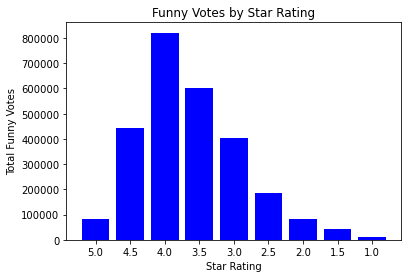

In [137]:
# Plot bar chart 

plt.bar(star_funny.stars, star_funny['sum(sum(funny))'], color='blue')
plt.xlabel('Star Rating')
plt.ylabel('Total Funny Votes')
plt.title('Funny Votes by Star Rating')
plt.savefig('funnyStar.png',dpi=300, bbox_inches = "tight")
plt.show()

## Funny Count by Business

In [61]:
# Use orberby, and join above DF with business

funny_business = business_star_funny.orderBy(['sum(funny)'], ascending=False)

funny_business = funny_business.join(business[['name', 'business_id']], how='left', on='business_id')
# Limit to top 10 
funny_business = funny_business.limit(10).toPandas()
funny_business

business_id stars  sum(funny)                              name
0  DN0b4Un8--Uf6SEWLeh0UA   3.0     49396.0            "Amy's Baking Company"
1  RESDUcs7fIiihp38-d6_6g   4.0      5330.0                "Bacchanal Buffet"
2  MpmFFw0GE_2iRFPdsRpJbA   4.0      4513.0                    "XS Nightclub"
3  5LNZ67Yw9RD6nf4_UhXOjw   4.0      4069.0   "The Cosmopolitan of Las Vegas"
4  K7lWdNUhCbcnEvI0NhGewg   3.5      4000.0                    "Wicked Spoon"
5  Iq7NqQD-sESu3vr9iEGuTA   4.5      3901.0         "Butters Pancakes & Café"
6  iCQpiavjjPzJ5_3gPD5Ebg   4.0      3636.0                    "Secret Pizza"
7  2weQS-RnoOBhb1KsHKyoSQ   3.5      3379.0                      "The Buffet"
8  FaHADZARwnY4yvlvpnsfGA   3.5      3330.0  "McCarran International Airport"
9  DkYS3arLOhA8si5uUEmHOw   4.5      3290.0                "Earl of Sandwich"

<BarContainer object of 10 artists>

Text(0.5, 0, 'Company Name')

Text(0, 0.5, 'Total Funny Votes')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

Text(0.5, 1.0, 'Funny Votes by Company')

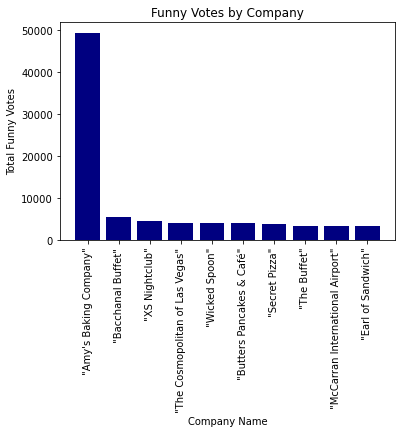

In [138]:
# Plot bar chart 

plt.bar(funny_business.name, funny_business['sum(funny)'], color='navy')
plt.xlabel('Company Name')
plt.ylabel('Total Funny Votes')
plt.xticks(rotation=90)
plt.title('Funny Votes by Company')
plt.savefig('funnyCompany.png',dpi=300, bbox_inches = "tight")
plt.show()

## Sum Cool by Stars

In [67]:
# Use groupby and sum 

review_cool = review.groupBy(review['business_id']).agg(F.sum(review['cool']))
review_cool.show()

+--------------------+---------+
|         business_id|sum(cool)|
+--------------------+---------+
|RtUvSWO_UZ8V3Wpj0...|   1024.0|
|jXjglUcr2bDKdoV4l...|     10.0|
|N3J76CRP2H52NUo4V...|     50.0|
|jOqh0eVjqtUOpZ9AZ...|     11.0|
|BMAflH82OUIMl2mHt...|     32.0|
|_ixV2SWDy7w8jzEAH...|    300.0|
|j0_CApMCHDJBYJg1X...|     83.0|
|CAmPPSKoFCd8zo2bx...|     10.0|
|YjPWt-V5oMkakdRWr...|     37.0|
|JsUytp_MuZ4AX5JWf...|     44.0|
|JFhfVTt_8xNjtwqSD...|     90.0|
|X26lmoKvv_KvW6WcA...|      4.0|
|MgSd4P3ATkiywbbra...|    131.0|
|JLbgvGM4FXh9zNP4O...|    976.0|
|1NmGVWYlF4iMngM6a...|     37.0|
|cz5vz-893D3LNH3TM...|    306.0|
|gogO5RF4Rqz2THF1A...|    131.0|
|b-dMCUh7T2Kya1O7Z...|     22.0|
|cdkzUI1tXc8rUMF33...|     13.0|
|Nf-Y0Ozjtff417vPS...|      6.0|
+--------------------+---------+
only showing top 20 rows



In [68]:
# Join business with DF from above 

business_star_cool = business[['stars','business_id']].join(review_cool, how='left', on='business_id')
business_star_cool.show()

+--------------------+-----+---------+
|         business_id|stars|sum(cool)|
+--------------------+-----+---------+
|fNMVV_ZX7CJSDWQGd...|  3.5|      5.0|
|l09JfMeQ6ynYs5MCJ...|  3.0|     17.0|
|8DShNS-LuFqpEWIp0...|  3.0|      5.0|
|NmZtoE3v8RdSJEczY...|  2.0|      0.0|
|IQSlT5jGE6CCDhSG0...|  3.0|      1.0|
|FYWN1wneV18bWNgQj...|  4.0|      4.0|
|KQPW8lFf1y5BT2Mxi...|  1.5|      1.0|
|OD2hnuuTJI9uotcKy...|  1.5|      7.0|
|o9eMRCWt5PkpLDE0g...|  4.0|      0.0|
|b2I2DXtZVnpUMCXp1...|  3.5|      2.0|
|xcgFnd-MwkZeO5G2H...|  4.0|     10.0|
|EsMcGiZaQuG1OOvL9...|  5.0|      5.0|
|kCoE3jvEtg6UVz5SO...|  4.0|      0.0|
|XOSRcvtaKc_Q5H1SA...|  4.5|      0.0|
|TGWhGNusxyMaA4kQV...|  5.0|      8.0|
|Gu-xs3NIQTj3Mj2xY...|  3.5|     13.0|
|He-G7vWjzVUysIKrf...|  3.0|      8.0|
|0FMKDOU8TJT1x87OK...|  5.0|      9.0|
|lHYiCS-y8AFjUitv6...|  4.0|      5.0|
|Y0eMNa5C-YU1RQOZf...|  5.0|      6.0|
+--------------------+-----+---------+
only showing top 20 rows



In [69]:
# Use groupby, sum, and orderby

star_cool = business_star_cool.groupBy(business_star_cool['stars']).agg(F.sum(business_star_cool['sum(cool)']))
star_cool = star_cool.orderBy(star_cool['stars'], ascending=False)
star_cool = star_cool.toPandas()
star_cool

stars  sum(sum(cool))
0   5.0        158015.0
1   4.5        653721.0
2   4.0       1064605.0
3   3.5        658926.0
4   3.0        333326.0
5   2.5        137257.0
6   2.0         50229.0
7   1.5         22090.0
8   1.0          5651.0

<BarContainer object of 9 artists>

Text(0.5, 0, 'Star Rating')

Text(0, 0.5, 'Total Cool Votes')

Text(0.5, 1.0, 'Cool Votes by Star Rating')

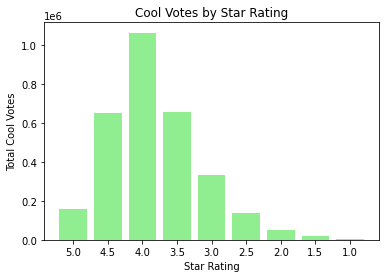

In [144]:
# Plot bar chart 

plt.bar(star_cool.stars, star_cool['sum(sum(cool))'], color='lightgreen')
plt.xlabel('Star Rating')
plt.ylabel('Total Cool Votes')
plt.title('Cool Votes by Star Rating')
plt.savefig('coolStar.png',dpi=300, bbox_inches = "tight")
plt.show()

## Cool Count by Business

In [71]:
# Use orderby and join and limit to top 10 businesses 

cool_business = business_star_cool.orderBy(['sum(cool)'], ascending=False)

cool_business = cool_business.join(business[['name', 'business_id']], how='left', on='business_id')
cool_business = cool_business.limit(10).toPandas()
cool_business

business_id stars  sum(cool)                              name
0  DN0b4Un8--Uf6SEWLeh0UA   3.0     9278.0            "Amy's Baking Company"
1  RESDUcs7fIiihp38-d6_6g   4.0     6039.0                "Bacchanal Buffet"
2  Iq7NqQD-sESu3vr9iEGuTA   4.5     4718.0         "Butters Pancakes & Café"
3  K7lWdNUhCbcnEvI0NhGewg   3.5     4562.0                    "Wicked Spoon"
4  5LNZ67Yw9RD6nf4_UhXOjw   4.0     4195.0   "The Cosmopolitan of Las Vegas"
5  iCQpiavjjPzJ5_3gPD5Ebg   4.0     4104.0                    "Secret Pizza"
6  DkYS3arLOhA8si5uUEmHOw   4.5     3854.0                "Earl of Sandwich"
7  4JNXUYY8wbaaDmk3BPzlWw   4.0     3747.0                    "Mon Ami Gabi"
8  FaHADZARwnY4yvlvpnsfGA   3.5     3707.0  "McCarran International Airport"
9  MpmFFw0GE_2iRFPdsRpJbA   4.0     3537.0                    "XS Nightclub"

<BarContainer object of 10 artists>

Text(0.5, 0, 'Company Name')

Text(0, 0.5, 'Total Cool Votes')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

Text(0.5, 1.0, 'Cool Votes by Company')

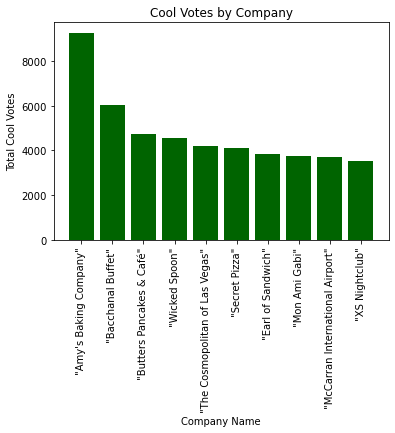

In [140]:
# Plot bar chart 

plt.bar(cool_business.name, cool_business['sum(cool)'], color='darkgreen')
plt.xlabel('Company Name')
plt.ylabel('Total Cool Votes')
plt.xticks(rotation=90)
plt.title('Cool Votes by Company')
plt.savefig('coolCompany.png',dpi=300, bbox_inches = "tight")
plt.show()

## Avg Sentence Length vs Useful Votes

In [77]:
from pyspark.sql.functions import length

# Add new column with review text length and define it as new variable 
rev_length = review.withColumn("len_text",length(col("text")))
rev_length.show()

+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+--------+
|           review_id|             user_id|         business_id|stars|      date|                text|useful|funny|cool|len_text|
+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+--------+
|vkVSCC7xljjrAI4UG...|bv2nCi5Qv5vroFiqK...|AEx2SYEUJmTxVVB18...|    5|2016-05-28|Super simple plac...|     0|    0|   0|     213|
|n6QzIUObkYshz4dz2...|bv2nCi5Qv5vroFiqK...|VR6GpWIda3SfvPC-l...|    5|2016-05-28|Small unassuming ...|     0|    0|   0|     502|
|MV3CcKScW05u5LVfF...|bv2nCi5Qv5vroFiqK...|CKC0-MOWMqoeWf6s-...|    5|2016-05-28|Lester's is locat...|     0|    0|   0|     373|
|IXvOzsEMYtiJI0CAR...|bv2nCi5Qv5vroFiqK...|ACFtxLv8pGrrxMm6E...|    4|2016-05-28|Love coming here....|     0|    0|   0|     523|
|L_9BTb55X0GDtThi6...|bv2nCi5Qv5vroFiqK...|s2I_Ni76bjJNK9yG6...|    4|2016-05-28|Had their

In [93]:
# Use select function 

useful_length = rev_length.select(['useful', 'len_text'])
useful_length = useful_length.toPandas()
useful_length

useful  len_text
0            0       213
1            0       502
2            0       373
3            0       523
4            0       231
...        ...       ...
5261663     36      1034
5261664      0       123
5261665      3       632
5261666      2      2021
5261667      0       953

[5261668 rows x 2 columns]

In [115]:
# Set up the bins 

bins = [0, 20, 100, 500, 1000, 2000, 3000, 4000, 5011]
useful_length['Bins'] = pd.cut(useful_length['len_text'], bins)
useful_length

useful  len_text          Bins  useful_int
0            0       213    (100, 500]           0
1            0       502   (500, 1000]           0
2            0       373    (100, 500]           0
3            0       523   (500, 1000]           0
4            0       231    (100, 500]           0
...        ...       ...           ...         ...
5261663     36      1034  (1000, 2000]          36
5261664      0       123    (100, 500]           0
5261665      3       632   (500, 1000]           3
5261666      2      2021  (2000, 3000]           2
5261667      0       953   (500, 1000]           0

[5261668 rows x 4 columns]

In [116]:
# Convert useful column to an integer

useful_length['useful_int']=useful_length['useful'].astype(str).astype(int)

In [117]:
# Make sure the conversion worked

useful_length.dtypes

useful          object
len_text         int32
Bins          category
useful_int       int64
dtype: object

In [118]:
# Use groupby and mean. I tried converting back to Spark DF, but it could not read data type of the bins

avg_useful_bins = useful_length.groupby('Bins', as_index=False)['useful_int'].mean()
avg_useful_bins

Bins  useful_int
0       (0, 20]    0.507177
1     (20, 100]    0.463653
2    (100, 500]    0.778589
3   (500, 1000]    1.622745
4  (1000, 2000]    2.749023
5  (2000, 3000]    4.251871
6  (3000, 4000]    5.538735
7  (4000, 5011]    6.935354

In [119]:
# Create new column of bins as strings for the bar plot in the next step

bins = ['(0, 20]','(20, 100]','(100, 500]','(500, 1000]','(1000, 2000]','(2000, 3000]','(3000, 4000]','(4000, 5011]']
avg_useful_bins['bins'] = bins
avg_useful_bins

Bins  useful_int          bins
0       (0, 20]    0.507177       (0, 20]
1     (20, 100]    0.463653     (20, 100]
2    (100, 500]    0.778589    (100, 500]
3   (500, 1000]    1.622745   (500, 1000]
4  (1000, 2000]    2.749023  (1000, 2000]
5  (2000, 3000]    4.251871  (2000, 3000]
6  (3000, 4000]    5.538735  (3000, 4000]
7  (4000, 5011]    6.935354  (4000, 5011]

<BarContainer object of 8 artists>

Text(0.5, 0, 'Review Character Length Bins')

Text(0, 0.5, 'Average Useful Votes')

([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

Text(0.5, 1.0, 'Average Useful Votes by Bin')

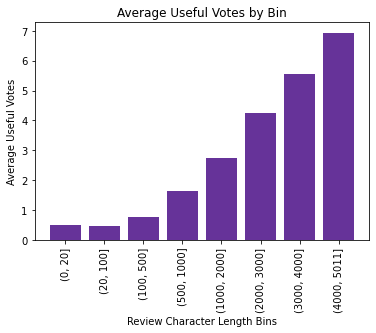

In [149]:
# Plor bar chart

plt.bar(avg_useful_bins.bins, avg_useful_bins['useful_int'], color='rebeccapurple')
plt.xlabel('Review Character Length Bins')
plt.ylabel('Average Useful Votes')
plt.xticks(rotation=90)
plt.title('Average Useful Votes by Bin')
plt.savefig('avgUsefulBins.png',dpi=300, bbox_inches = "tight")
plt.show()

## Average Review Length and Useful Count Per User

In [80]:
# Use select function 

user_textlength = rev_length.select(['review_id', 'user_id', 'useful', 'len_text'])
user_textlength.show()

+--------------------+--------------------+------+--------+
|           review_id|             user_id|useful|len_text|
+--------------------+--------------------+------+--------+
|vkVSCC7xljjrAI4UG...|bv2nCi5Qv5vroFiqK...|     0|     213|
|n6QzIUObkYshz4dz2...|bv2nCi5Qv5vroFiqK...|     0|     502|
|MV3CcKScW05u5LVfF...|bv2nCi5Qv5vroFiqK...|     0|     373|
|IXvOzsEMYtiJI0CAR...|bv2nCi5Qv5vroFiqK...|     0|     523|
|L_9BTb55X0GDtThi6...|bv2nCi5Qv5vroFiqK...|     0|     231|
|HRPm3vEZ_F-33TYVT...|_4iMDXbXZ1p1ONG29...|     1|     471|
|ymAUG8DZfQcFTBSOi...|u0LXt3Uea_GidxRW1...|     0|     601|
|8UIishPUD92hXtScS...|u0LXt3Uea_GidxRW1...|     1|     251|
|w41ZS9shepfO3uEyh...|u0LXt3Uea_GidxRW1...|     1|     244|
|WF_QTN3p-thD74hqp...|u0LXt3Uea_GidxRW1...|     3|     306|
|PIsUSmvaUWB00qv5K...|u0LXt3Uea_GidxRW1...|     1|     413|
|PdZ_uFjbbkjtm3SCY...|u0LXt3Uea_GidxRW1...|     5|     155|
|x5oV6wm9_Pb1QQ6jk...|u0LXt3Uea_GidxRW1...|     9|    1072|
|lsoSqIrrDbQvWpMvs...|u0LXt3Uea_GidxRW1.

In [85]:
# Use groupby and average the review length 

avg_length = user_textlength.groupBy(user_textlength.user_id).agg(F.avg(user_textlength.len_text))
avg_length.show()

In [87]:
# Use groupby and sum the useful votes 

toBeJoined = user_textlength.groupBy(user_textlength.user_id).agg(F.sum(user_textlength.useful))
toBeJoined.show()

+--------------------+-----------+
|             user_id|sum(useful)|
+--------------------+-----------+
|oKWVVqPWVzq5s6nS4...|       17.0|
|OcB8_br3QOUuX_CCg...|        0.0|
|5a7nRCjFm_QUjF8xy...|        0.0|
|DsPTtxXzLccDutfoJ...|        8.0|
|Y1N3yo62V5eIj_Zcn...|        0.0|
|qxpk8rO10eJ4_NGta...|        0.0|
|G5doo_5gjzejaECHv...|        8.0|
|TcRbqnOv6Mqfvhsdj...|       19.0|
|Q87V0vOAtbpxdkrF6...|        2.0|
|3F9rvmlmr6FHUronu...|        5.0|
|32vx6QPtlUvMFurvb...|        0.0|
|MFoN8dduPz4mwDMu1...|        2.0|
|bSA6m2r1k67uaEPCc...|        0.0|
|LEr8vS6PRymCg-SJH...|       20.0|
|_fuXIiQGOo0RrdzjQ...|        0.0|
|Xf2tlT1czROOdOgTG...|        0.0|
|xwL6r5RL8K81s6T1o...|        0.0|
|PqUQyGApS2pho7aox...|        0.0|
|2Hw061_FYIUKYIILd...|        1.0|
|KuGQIxKfGiHLNRuWL...|       63.0|
+--------------------+-----------+
only showing top 20 rows



In [150]:
# join the previous 2 DF's together

avg_length_useful = avg_length.join(toBeJoined, how = 'left', on='user_id').orderBy('avg(len_text)', ascending=False)

In [151]:
avg_length_useful.show()

+--------------------+-------------+-----------+
|             user_id|avg(len_text)|sum(useful)|
+--------------------+-------------+-----------+
|2oMPMcl5w9wpaQ6sW...|       5010.0|       15.0|
|LhuM5GQWE5OUb8m6t...|       5009.0|        7.0|
|noa172bEZrNwlOmid...|       5008.0|       50.0|
|YhNRPq9rVzYkfVf4R...|       5008.0|        9.0|
|kDe2ffFTPGEez2qyY...|       5008.0|        0.0|
|0x6xNj-v8MOpX_UoZ...|       5007.0|        2.0|
|t6-cKqJZtMZsfUBgL...|       5006.0|       12.0|
|wl6hn4IgR2kHS6N9K...|       5006.0|        2.0|
|PcV-7xsFcB4fWRK8w...|       5006.0|        1.0|
|h5Cayjbp87eFLMv1A...|       5005.0|        0.0|
|N7cqWsTgVSRFN3lv_...|       5005.0|        4.0|
|rwzd2Iy9fRKIk2iMn...|       5005.0|        4.0|
|Cbh8HgJt_9cdou7wv...|       5005.0|        3.0|
|3M4B14JpHSXleZo9K...|       5004.0|        0.0|
|W_6ZXNTlZxm32-FGk...|       5004.0|        4.0|
|tWIj6hRlSl7cxxOC0...|       5004.0|        3.0|
|_jLRCnICt4PHxbk_v...|       5004.0|       28.0|
|XWFgSa4AjJMswAUHa..

In [157]:
# Join the previouly joined DF with user to get user names 

avg_length_useful.join(user[['name', 'user_id']], how='left', on='user_id').orderBy('sum(useful)', ascending = False).show()

+--------------------+------------------+-----------+--------+
|             user_id|     avg(len_text)|sum(useful)|    name|
+--------------------+------------------+-----------+--------+
|bLbSNkLggFnqwNNzz...|1089.1550312951372|    23572.0| Stefany|
|Fv0e9RIV9jw5TX3ct...| 1570.322241681261|    17404.0|Christie|
|zFYs8gSUYDvXkb6O7...|1301.6336633663366|    17231.0|   Joyce|
|8DEyKVyplnOcSKx39...| 1017.583870967742|    13981.0|  Philip|
|DK57YibC5ShBmqQl9...| 965.6589200273411|    13175.0|   Karen|
|PKEzKWv_FktMm2mGP...|1198.2706393544383|    12078.0|    Norm|
|M9rRM6Eo5YbKLKMG5...|1977.8776978417266|    11892.0|  Aileen|
|CxDOIDnH8gp9KXzpB...| 798.1574670776128|    11345.0|Jennifer|
|qewG3X2O4X6JKskxy...|1279.3123287671233|    10413.0|   Misti|
|rCWrxuRC8_pfagpch...|1870.8218579234972|    10199.0|  Darren|
|A0j21z2Q1HGic7jW6...| 964.0129659643436|     9871.0| Georgie|
|dIIKEfOgo0KqUfGQv...|1235.1425682507584|     9476.0|    Gabi|
|QJI9OSEn6ujRCtrX0...| 955.2534039334342|     8748.0|  